# Setup

## Libraries Used

In [117]:
from skopt import gp_minimize
from skopt import dummy_minimize
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
import datetime as dt
import category_encoders as ce
import scipy.stats as stats
from scipy.stats import skew
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import math
import pandas as pd
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

## Importing Data

In [3]:
train = pd.read_csv(r"data\fraudTrain.csv", index_col=0)
pd.options.display.float_format = '{:,.2f}'.format

# Data Cleansing

First we'll have a look at our data.

In [4]:
train.head(3)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.08,-81.18,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.01,-82.05,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.89,-118.21,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.16,-118.19,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.18,-112.26,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.15,-112.15,0


In [5]:
train.shape

(1296675, 22)

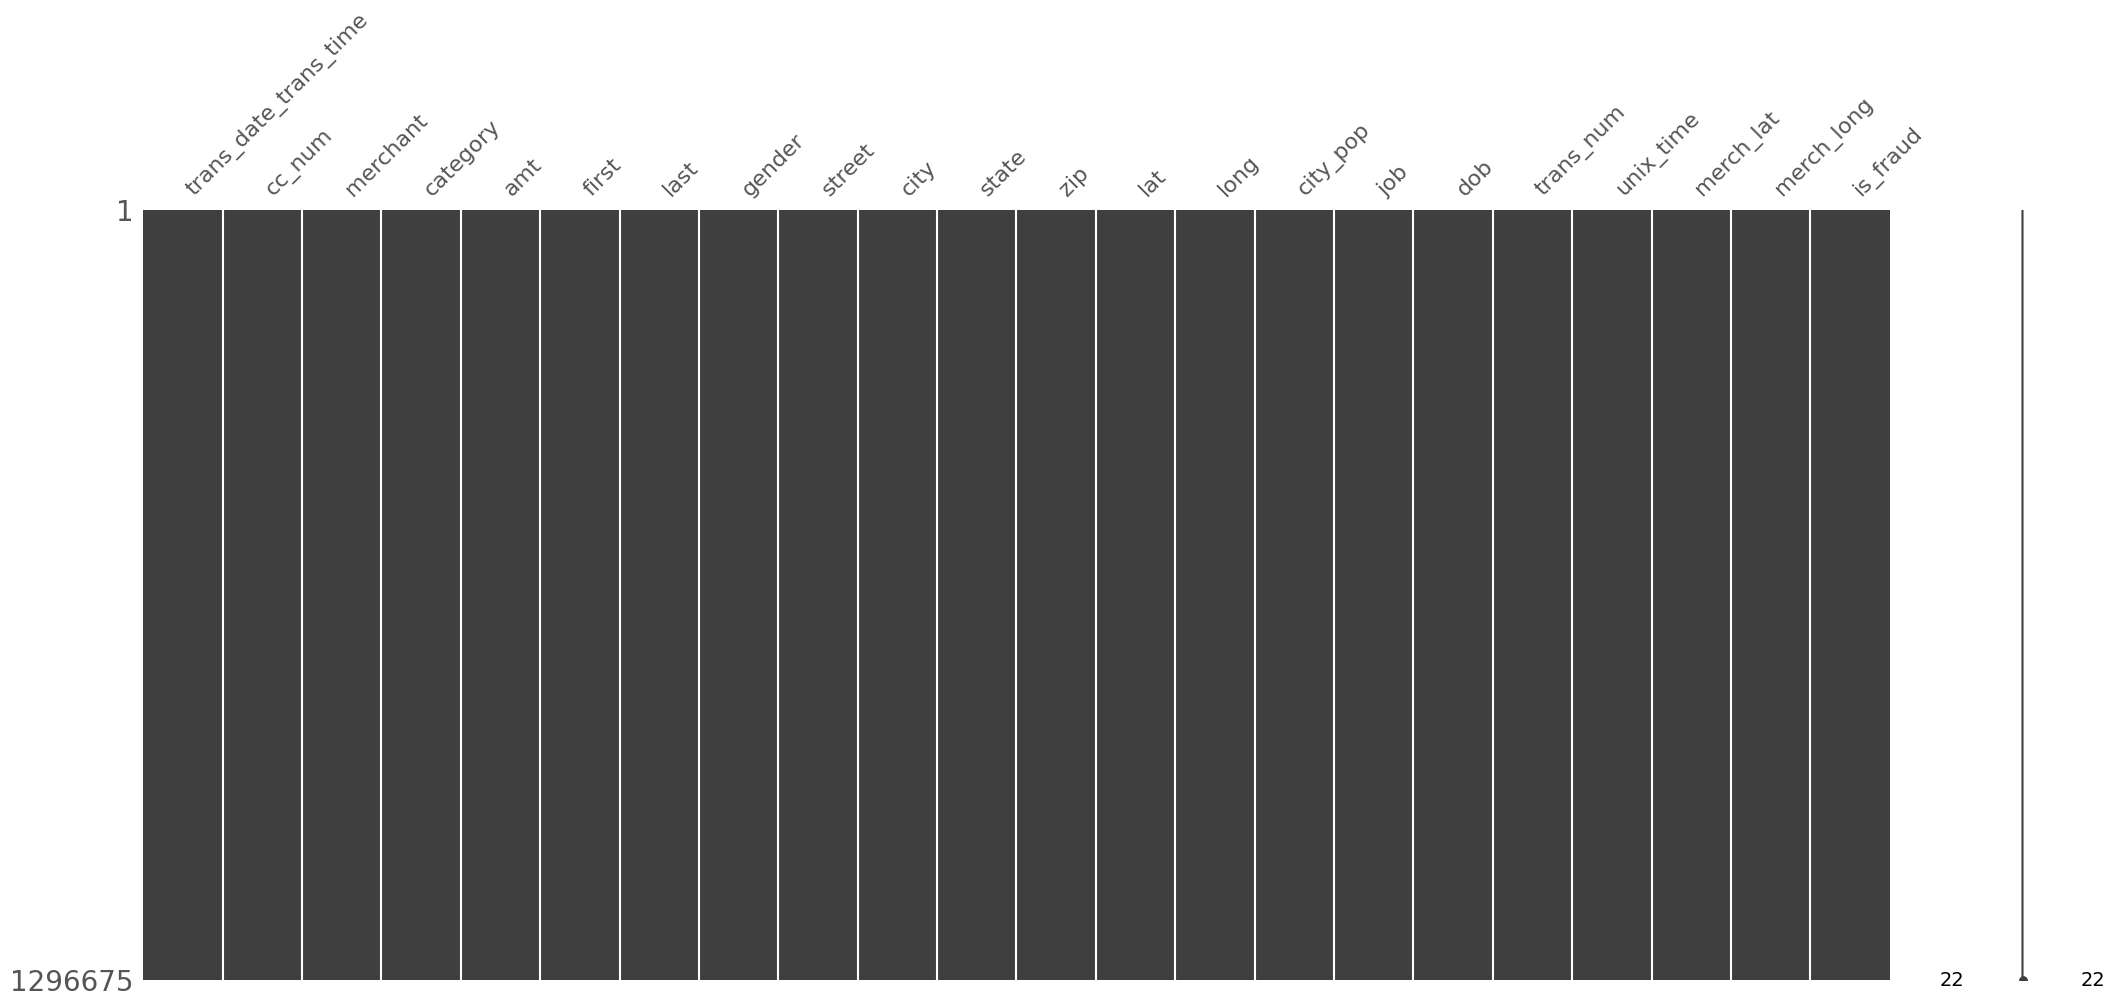

In [6]:
msno.matrix(train);

In [7]:
train.isna().sum()

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

As we can see, there is no missing values!

# Exploratory Data Analysis (EDA)

In [8]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
cc_num,"1,296,675.00","417,192,042,079,726,656.00","1,308,806,447,000,240,384.00","60,416,207,185.00","180,042,946,491,150.00","3,521,417,320,836,166.00","4,642,255,475,285,942.00","4,992,346,398,065,154,048.00"
amt,"1,296,675.00",70.35,160.32,1.00,9.65,47.52,83.14,"28,948.90"
zip,"1,296,675.00","48,800.67","26,893.22","1,257.00","26,237.00","48,174.00","72,042.00","99,783.00"
lat,"1,296,675.00",38.54,5.08,20.03,34.62,39.35,41.94,66.69
long,"1,296,675.00",-90.23,13.76,-165.67,-96.80,-87.48,-80.16,-67.95
city_pop,"1,296,675.00","88,824.44","301,956.36",23.00,743.00,"2,456.00","20,328.00","2,906,700.00"
unix_time,"1,296,675.00","1,349,243,636.73","12,841,278.42","1,325,376,018.00","1,338,750,742.50","1,349,249,747.00","1,359,385,375.50","1,371,816,817.00"
merch_lat,"1,296,675.00",38.54,5.11,19.03,34.73,39.37,41.96,67.51
merch_long,"1,296,675.00",-90.23,13.77,-166.67,-96.90,-87.44,-80.24,-66.95
is_fraud,"1,296,675.00",0.01,0.08,0.00,0.00,0.00,0.00,1.00


In [9]:
train["amt"].describe()

count   1,296,675.00
mean           70.35
std           160.32
min             1.00
25%             9.65
50%            47.52
75%            83.14
max        28,948.90
Name: amt, dtype: float64

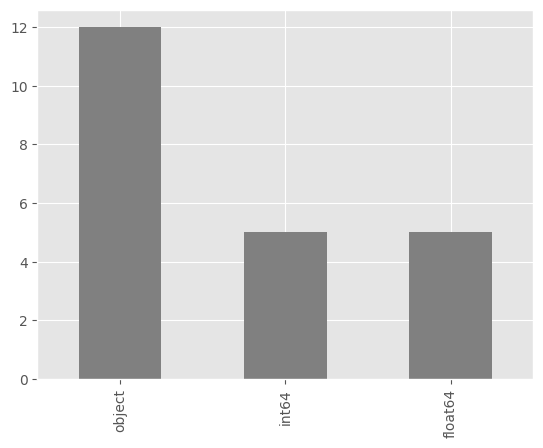

In [10]:
train.dtypes.value_counts().plot(kind='bar', color="grey");

There are a lot of categorical features! So we are probably going to consider categorical encoding.

## Univariate analysis

Lets check the target imbalance!

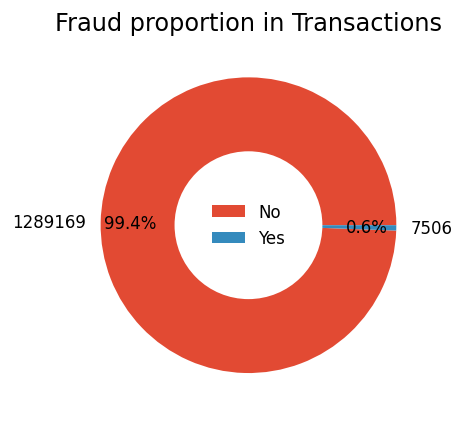

In [11]:
donut = train["is_fraud"].value_counts().reset_index()

labels = ["No", "Yes"]
explode = (0, 0)

fig, ax = plt.subplots(dpi=120, figsize=(8, 4))
plt.pie(donut["is_fraud"],
        labels=donut["is_fraud"],
        autopct="%1.1f%%",
        pctdistance=0.8,
        explode=explode)

centre_circle = plt.Circle((0.0, 0.0), 0.5, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title("Fraud proportion in Transactions")
plt.legend(labels, loc="center", frameon=False)
plt.show();

We have a severe imbalance dataset. Because of this, Oversampling/Undersampling will be considered in the model.

Let's check the distribution of the amount ("amt") feature.

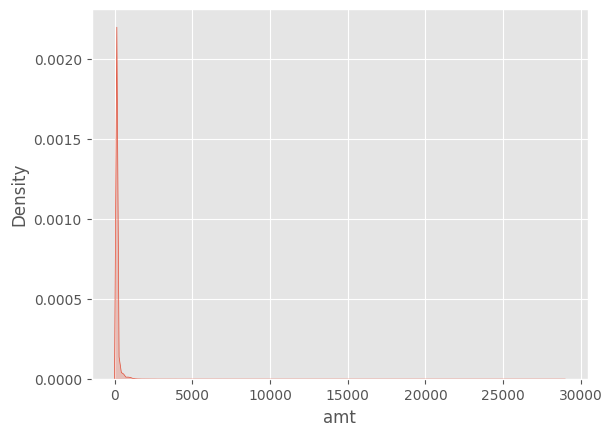

In [12]:
sns.kdeplot(train["amt"], fill=True);

Higher values of amount is distorting the graph. So we fix it plotting only 0-99% of amount.

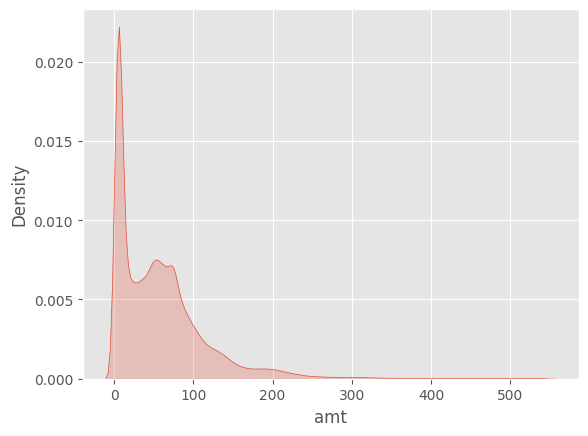

In [13]:
p99 = train["amt"].quantile(0.99)
sns.kdeplot(x="amt", data=train[train["amt"] <= p99], fill=True);

Lets se if there is any noticeable pattern between the target (is_fraud) and amount.

## Multivariate analysis

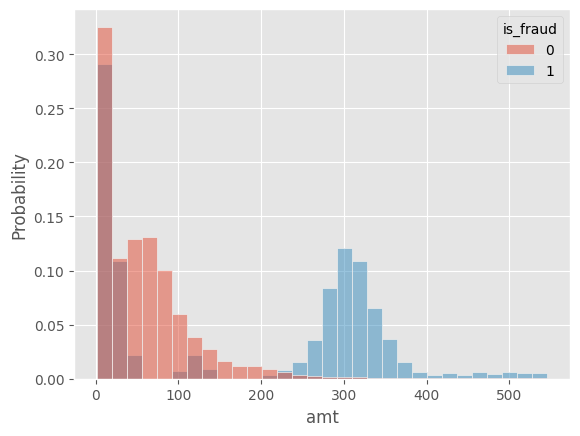

In [14]:
p99 = train["amt"].quantile(0.99)
sns.histplot(x="amt", hue="is_fraud", bins=30,
             stat="probability", data=train[train["amt"] <= p99],
             common_norm=False);

Notice that the probability distribution behaves differently for each value of "is_fraud".

We can expand this analysis to each transaction category:

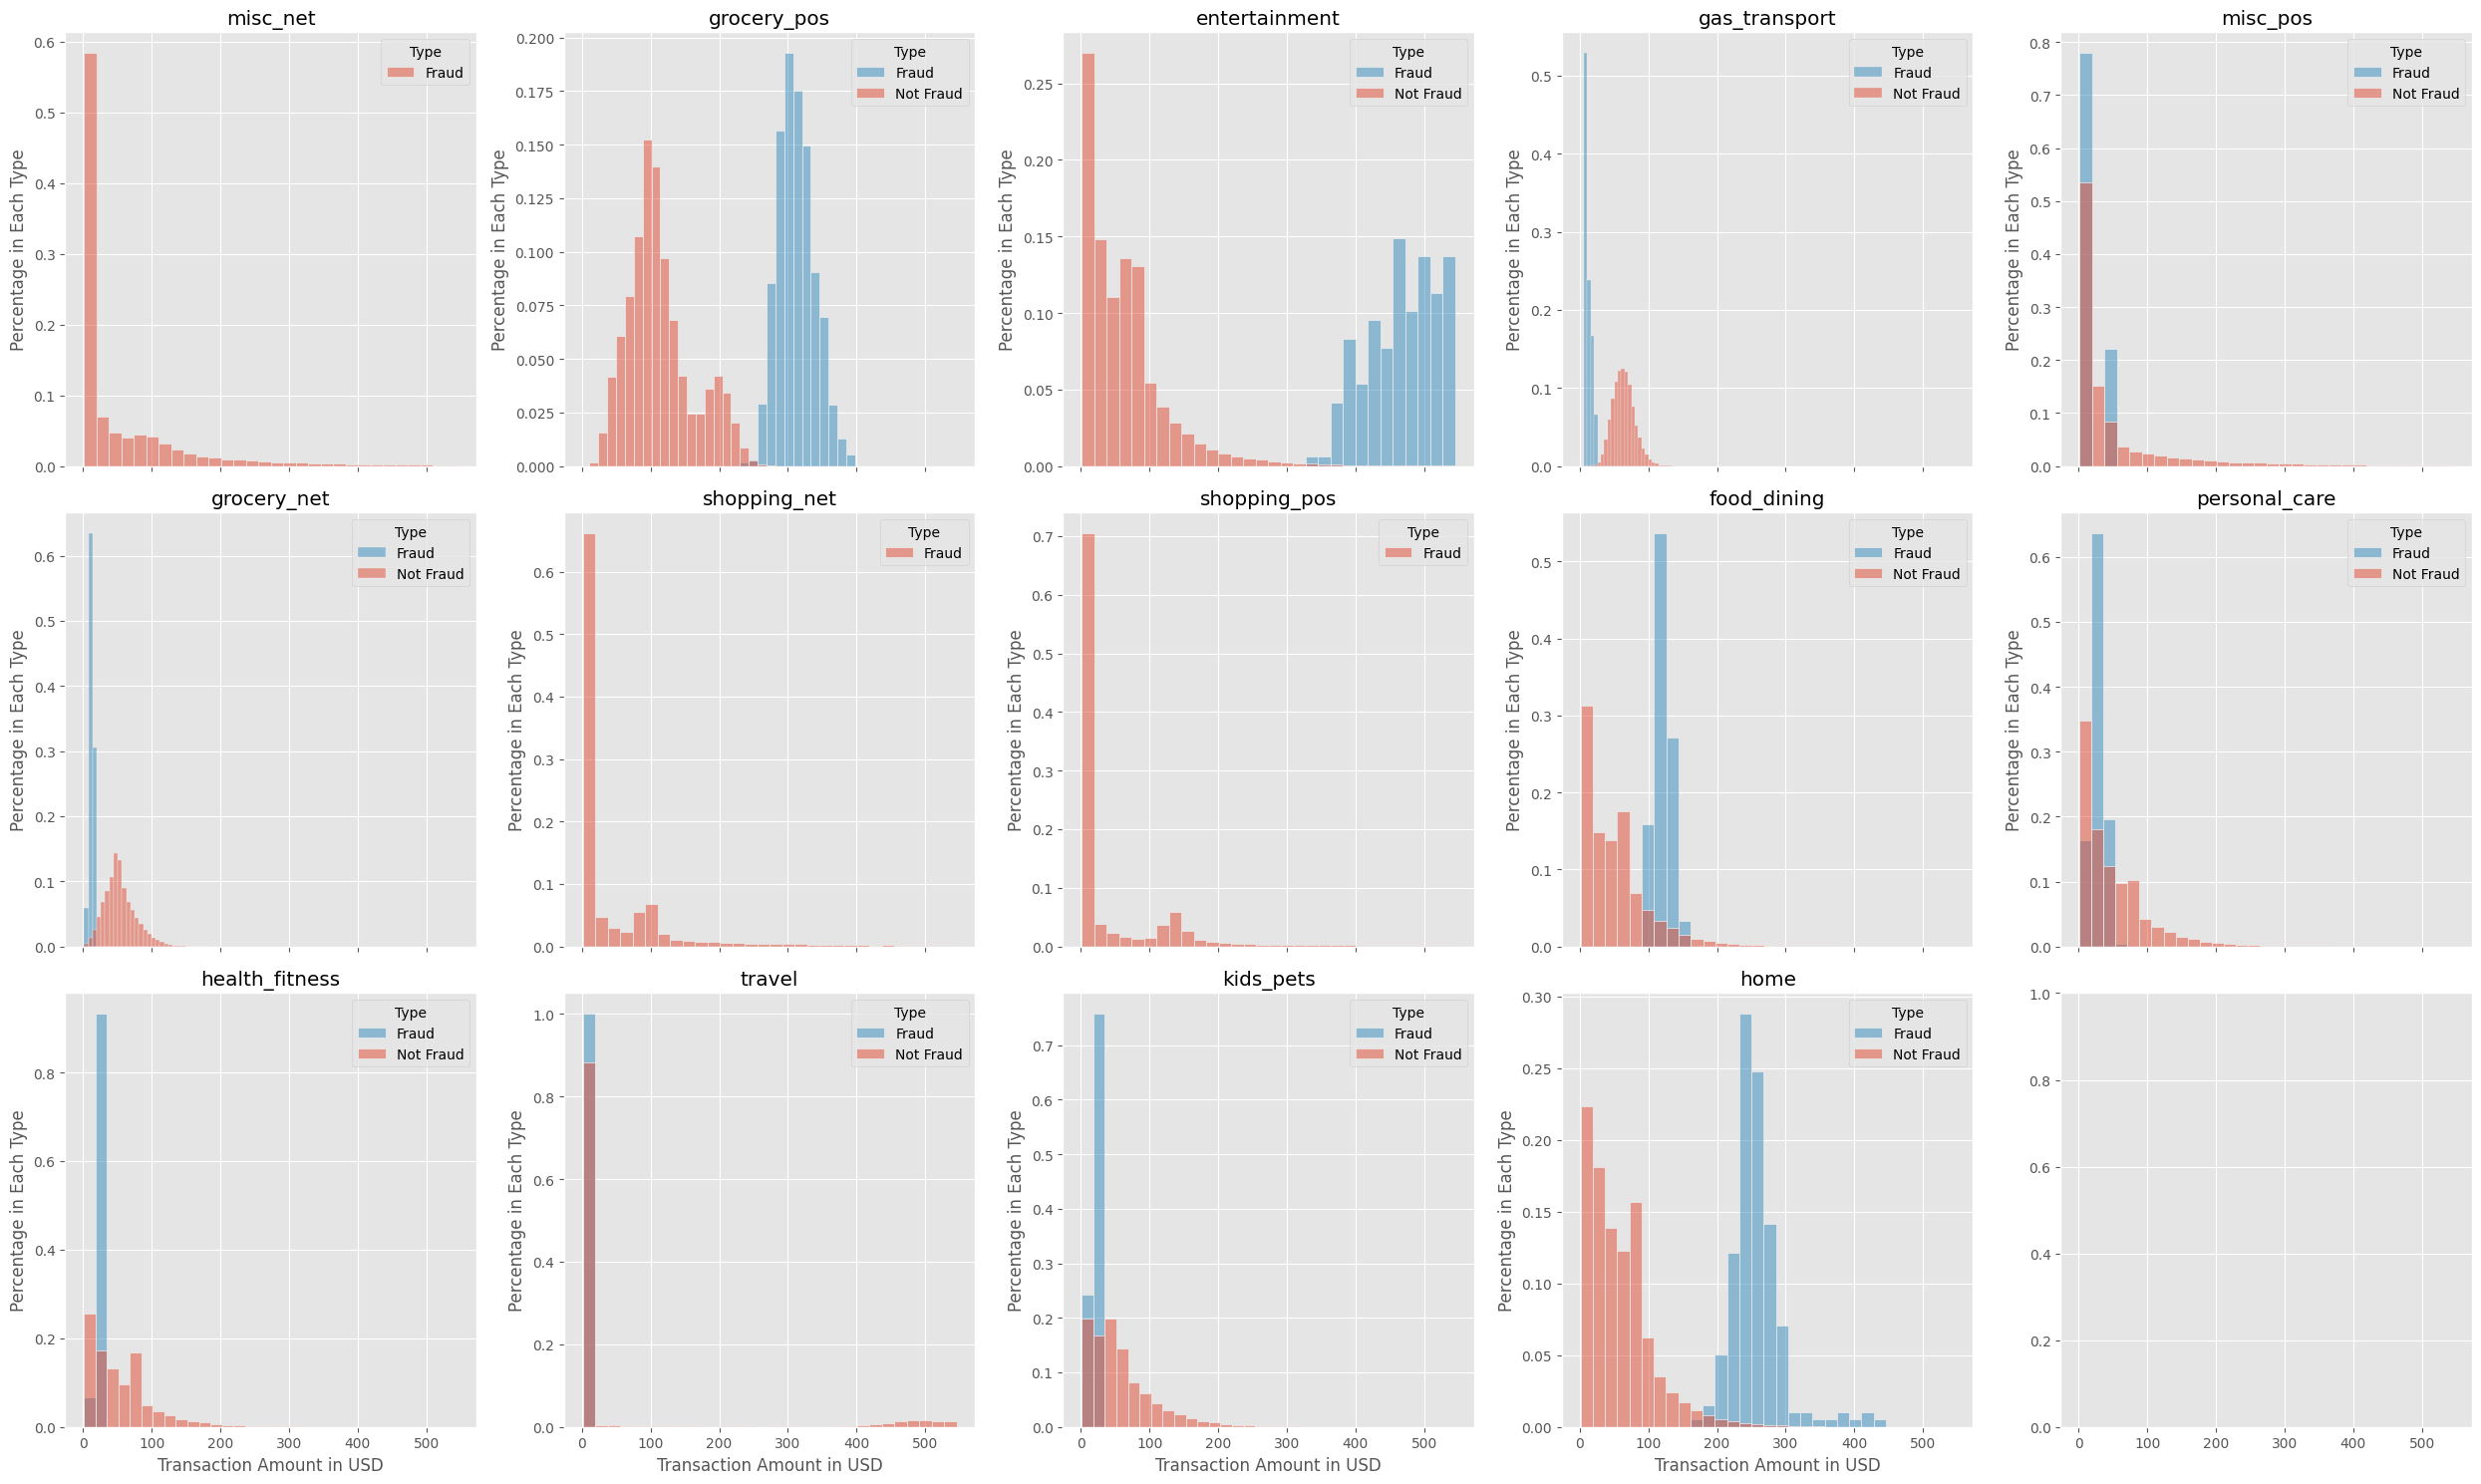

In [15]:
categories = train['category'].unique()

num_plots = len(categories)
num_rows = math.isqrt(num_plots)
num_cols = math.ceil(num_plots / num_rows)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(
    5*num_cols, 5*num_rows), sharex=True)

for i, category in enumerate(categories):

    row = i // num_cols
    col = i % num_cols

    data_category = train[train['category'] == category]

    if num_rows == 1 and num_cols == 1:
        ax = axes
    elif num_rows == 1 or num_cols == 1:
        ax = axes[i]
    else:
        ax = axes[row, col]

    sns.histplot(x='amt', data=data_category[data_category['amt'] <= p99],
                 hue='is_fraud', stat='probability',
                 common_norm=False, bins=30, ax=ax)

    ax.set_ylabel('Percentage in Each Type')
    ax.set_xlabel('Transaction Amount in USD')
    ax.set_title(f'{category}')
    ax.legend(title='Type', labels=['Fraud', 'Not Fraud'])

plt.tight_layout()

plt.show();

Lets dive into categories. We'll analyze which categories the frauds are more frequently. For this, we'll calculate the distribution for each category for normal transactions and then the distribution for fraudulents transactions. Then, we take the difference between the two distributions. This difference shows us the categories that are most predominants to have frauds.

In [16]:
# non_fraud
non_fraud = train[train['is_fraud'] == 0]['category'].value_counts(
    normalize=True).to_frame().reset_index()
non_fraud.columns = ['category', 'not_fraud_percentual_vs_total']

# fraud
fraud = train[train['is_fraud'] == 1]['category'].value_counts(
    normalize=True).to_frame().reset_index()
fraud.columns = ['category', 'fraud_percentage_vs_total']

# merging two dataframes and calculating "fraud level"
non_fraud_vs_fraud = non_fraud.merge(fraud, on='category')
non_fraud_vs_fraud['fraud_level'] = non_fraud_vs_fraud['fraud_percentage_vs_total'] - \
    non_fraud_vs_fraud['not_fraud_percentual_vs_total']

non_fraud_vs_fraud

,category,not_fraud_percentual_vs_total,fraud_percentage_vs_total,fraud_level
0,gas_transport,0.10,0.08,-0.02
1,home,0.10,0.03,-0.07
2,grocery_pos,0.09,0.23,0.14
3,shopping_pos,0.09,0.11,0.02
4,kids_pets,0.09,0.03,-0.06
5,shopping_net,0.07,0.23,0.15
6,entertainment,0.07,0.03,-0.04
7,food_dining,0.07,0.02,-0.05
8,personal_care,0.07,0.03,-0.04
9,health_fitness,0.07,0.02,-0.05


Note that the columns "not_fraud_percentual_vs_total" and "fraud_percentage_vs_total" sums up to 1. That's because we are taking the percentual of each category on total, for fraud and not fraud, and calculating the "fraud_level" metric, that shows which category is more common to have frauds.

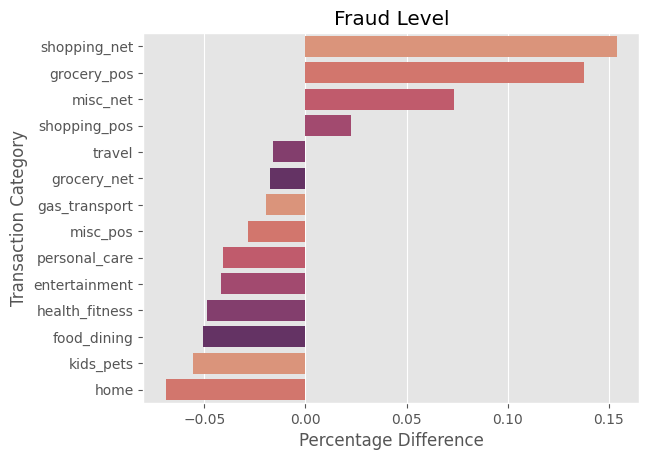

In [17]:
custom_palette = sns.color_palette("flare")
ax = sns.barplot(y='category', x='fraud_level',
                 data=non_fraud_vs_fraud.sort_values('fraud_level', ascending=False), palette=custom_palette)
ax.set_xlabel('Percentage Difference')
ax.set_ylabel('Transaction Category')
plt.title('Fraud Level');

As shown above, some categories are more propicious to have frauds than others.

Let's see how the Age distribution behaves for fraud and non-fraud transactions.

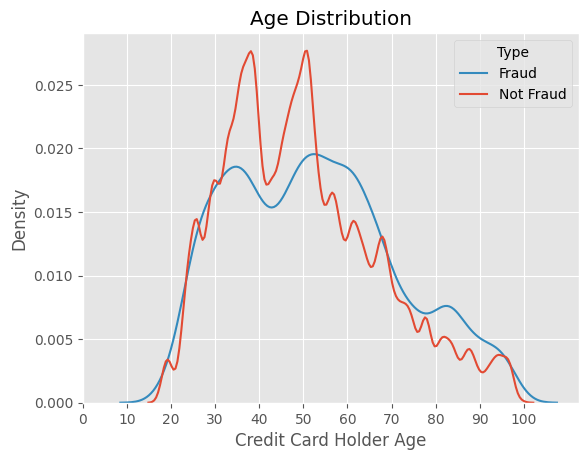

In [18]:
train['age'] = dt.date.today().year-pd.to_datetime(train['dob']).dt.year
ax = sns.kdeplot(x='age', data=train, hue='is_fraud', common_norm=False)
ax.set_xlabel('Credit Card Holder Age')
ax.set_ylabel('Density')
plt.xticks(np.arange(0, 110, 10))
plt.title('Age Distribution')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud']);

We can observe that in non-fraudulent transactions, there is a peak around 35 years and 40 years, and another one around 50 years. On the other hand, in fraudulent operations, we observe a smoother distribution, with peaks around 35 years and in the range of 50 years to 55 years.

Let's analyze if the time in a day has any impact.

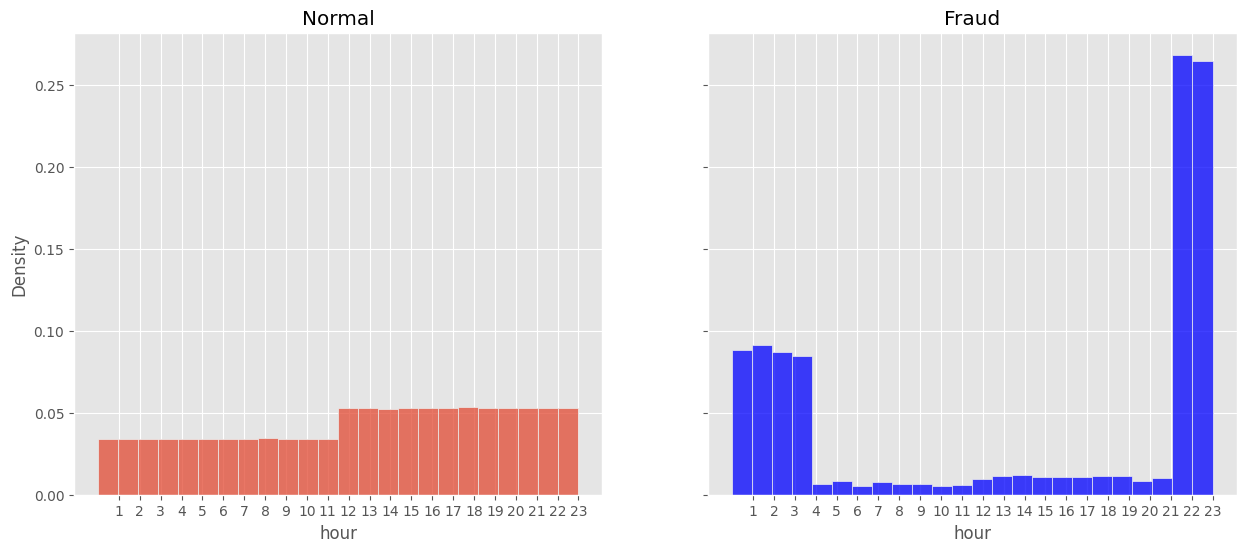

In [19]:
train['hour'] = pd.to_datetime(train['trans_date_trans_time']).dt.hour
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax1 = sns.histplot(x='hour', data=train[train["is_fraud"] == 0],
                   stat="density", bins=24, ax=ax1)
ax2 = sns.histplot(x='hour', data=train[train["is_fraud"] == 1],
                   stat="density", bins=24, ax=ax2, color="blue")
ax1.set_title("Normal")
ax2.set_title("Fraud")
ax1.set_xticks(np.arange(1, 24))
ax2.set_xticks(np.arange(1, 24));

As we can see, there is a clear pattern when it comes to hour in the day. Fraudulent payments happens more frequently around midnight than in normal transactions.

Let's do the same for months!

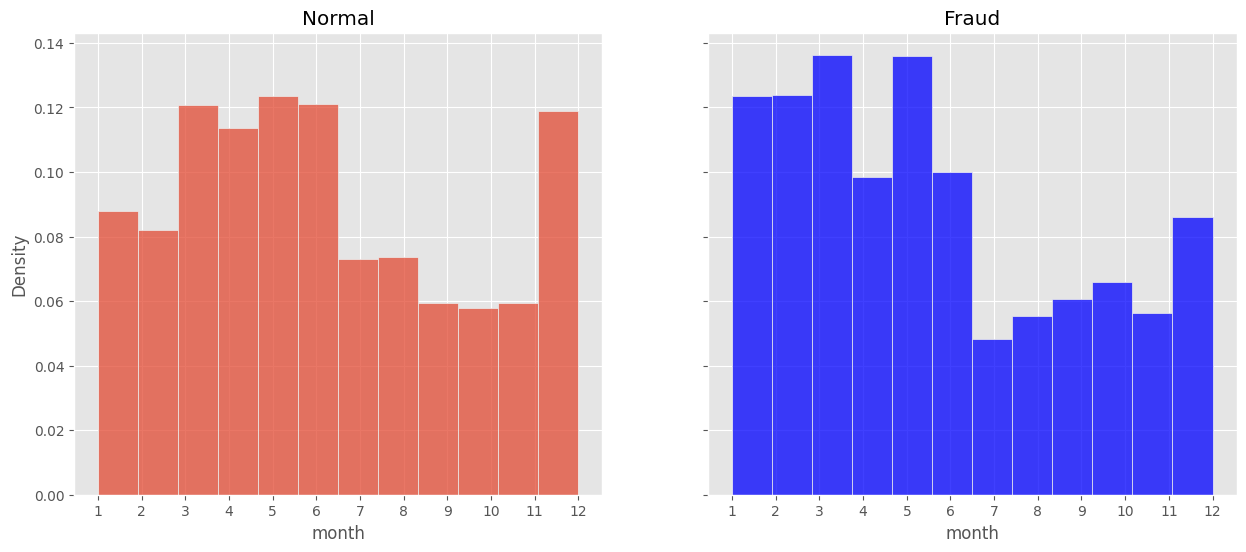

In [20]:
train['month'] = pd.to_datetime(train['trans_date_trans_time']).dt.month
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax1 = sns.histplot(x='month', data=train[train["is_fraud"] == 0],
                   stat="density", bins=12, ax=ax1)
ax2 = sns.histplot(x='month', data=train[train["is_fraud"] == 1],
                   stat="density", bins=12, ax=ax2, color="blue")
ax1.set_title("Normal")
ax2.set_title("Fraud")
ax1.set_xticks(np.arange(1, 13))
ax2.set_xticks(np.arange(1, 13));

# Feature Engineering

First, let's drop some columns that has duplicated or not useful information

In [21]:
train.drop(columns=["merchant", "first", "last", "street",
           "unix_time", "trans_num"], inplace=True)

In [22]:
train.head(2)

,trans_date_trans_time,cc_num,category,amt,gender,city,state,zip,lat,long,city_pop,job,dob,merch_lat,merch_long,is_fraud,age,hour,month
0,2019-01-01 00:00:18,2703186189652095,misc_net,4.97,F,Moravian Falls,NC,28654,36.08,-81.18,3495,"Psychologist, counselling",1988-03-09,36.01,-82.05,0,35,0,1
1,2019-01-01 00:00:44,630423337322,grocery_pos,107.23,F,Orient,WA,99160,48.89,-118.21,149,Special educational needs teacher,1978-06-21,49.16,-118.19,0,45,0,1


We saw that the "amt" category has very little spacing between small numbers and large spacing between high numbers. Because of that, we are going to use non logarithm scaling, that increases the distance between small values and reduces de spacing between large ones.

## Scaling

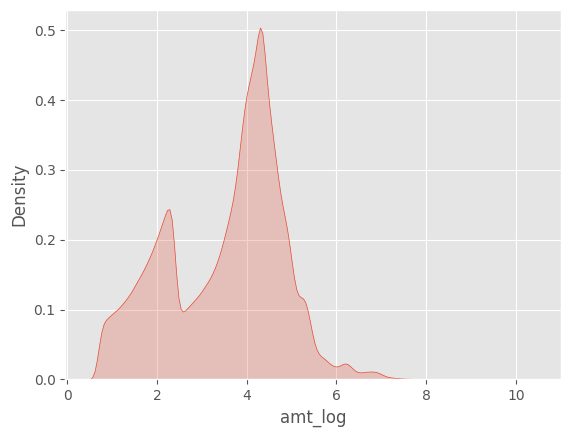

In [23]:
train["amt_log"] = np.log1p(train["amt"])
sns.kdeplot(train["amt_log"], fill=True);

Let's check the normality of the "amt" feature compared to its transformation "amt_log".

In [24]:
def check_normality(feature):
    plt.figure(figsize=(8, 8))
    ax1 = plt.subplot(1, 1, 1)
    stats.probplot(train[feature], dist=stats.norm, plot=ax1)
    ax1.set_title(f'{feature} Q-Q plot', fontsize=20)
    sns.despine()

    mean = train[feature].mean()
    std = train[feature].std()
    skew = train[feature].skew()
    print(f'{feature} : mean: {mean:.2f}, std: {std:.2f}, skew: {skew:.2f}')

amt : mean: 70.35, std: 160.32, skew: 42.28


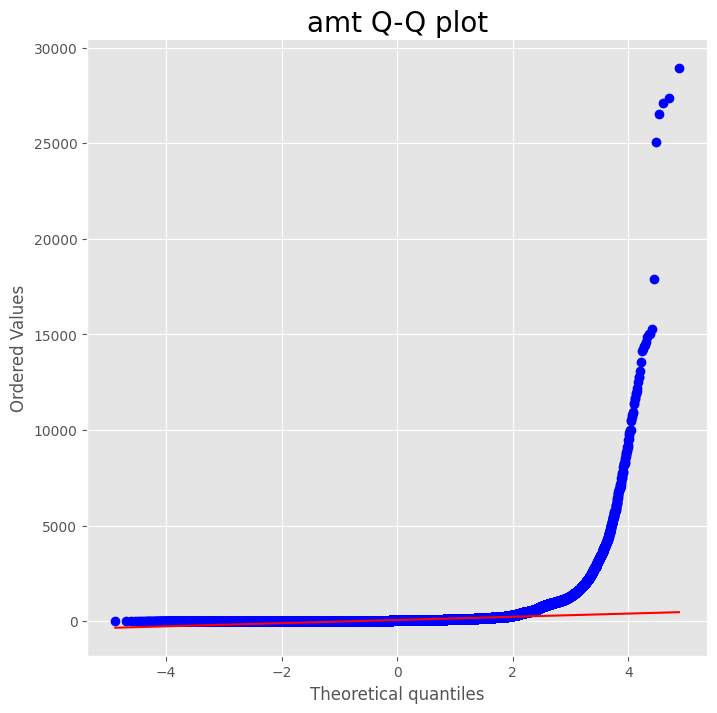

In [25]:
check_normality("amt");

amt_log : mean: 3.53, std: 1.29, skew: -0.30


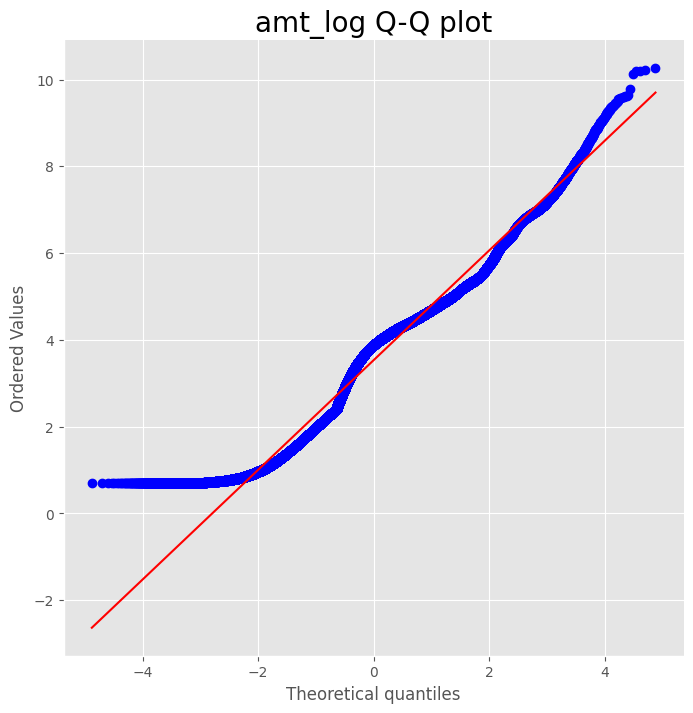

In [26]:
check_normality("amt_log");

We can see that with the logarithm scaling, the skewness has improved a lot.

## Categorical Encoding

Since we have a binary target and categorical variables with high cardinality, we are going to use the WOE (Weight of Evidence) encoder for the features: category, state, city and job.

In [27]:
def apply_woe(train, columns, target_col):
    woe = ce.WOEEncoder()

    for col in columns:
        X = train[col]
        y = train[target_col]

        new_col_name = f"{col}_WOE"
        train[new_col_name] = woe.fit_transform(X, y)

    return train


columns_to_encode = ["category", "state", "city", "job"]
target_column = "is_fraud"

train = apply_woe(train, columns_to_encode, target_column)

As for gender category, we can simply encode it by using dummies.

In [28]:
gender_mapping = {"F": 0, "M": 1}

train["gender_binary"] = train["gender"].map(gender_mapping)

We can encode the cc_num (credit card number) variable as well, by counting their frequencies in the database and them dividing them into classes, so we can classify the cards that are used a lot, and the ones that are not used often in the database.

In [29]:
freq_enc = (train.groupby("cc_num").size())
freq_enc.sort_values(ascending=True)
train["cc_num_frequency"] = train["cc_num"].apply(lambda x: freq_enc[x])

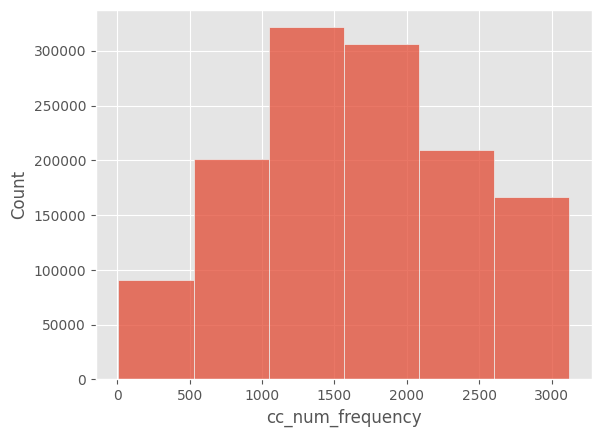

In [30]:
sns.histplot(train["cc_num_frequency"], bins=6);

In [31]:
intervals = [600, 1200, 1800, 2400, 3000, 3600]


def classify_frequency(freq):
    for i, c in enumerate(intervals):
        if freq <= c:
            return i


train["cc_num_frequency_classification"] = train["cc_num_frequency"].apply(
    classify_frequency)

Let's see if the distributions are different among the frequency classes for fraudulent and non-fraudulent transactions.

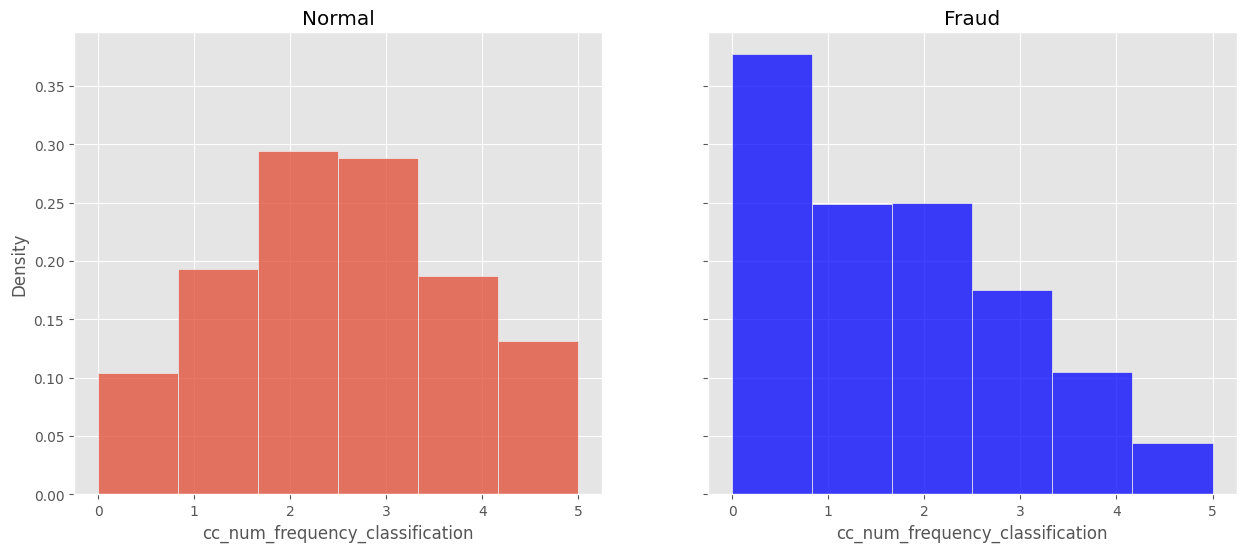

In [32]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax1 = sns.histplot(x='cc_num_frequency_classification', data=train[train["is_fraud"] == 0],
                   stat="density", bins=6, ax=ax1)
ax2 = sns.histplot(x='cc_num_frequency_classification', data=train[train["is_fraud"] == 1],
                   stat="density", bins=6, ax=ax2, color="blue")
ax1.set_title("Normal")
ax2.set_title("Fraud");

As we can see, there is a clear pattern happening. Frauds are more propitious to happen in credit cards with less use (new ones), and when it comes to normal transactions, it follows a normal distribution.

# Undersampling

As we saw, our data is very imbalanced. Because of that, we are going to use Undersampling in our favor. The method that we are going to use is the RandomUnderSampler.

In [33]:
X = train.drop(columns=["is_fraud"])
y = train["is_fraud"]

In [34]:
rus = RandomUnderSampler(sampling_strategy=0.1, random_state=23)

In [35]:
X_undersampled, y_undersampled = rus.fit_resample(X, y)

Let's check our proportion after the Undersampling.

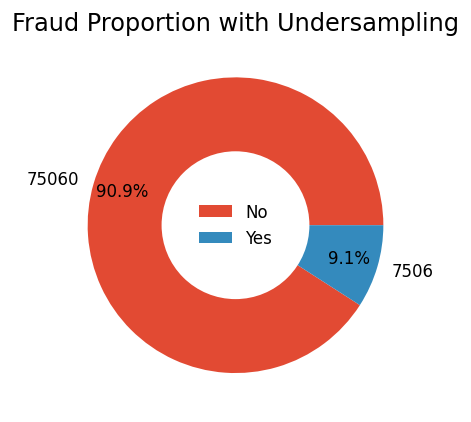

In [36]:
donut = y_undersampled.value_counts().reset_index()

labels = ["No", "Yes"]
explode = (0, 0)

fig, ax = plt.subplots(dpi=120, figsize=(8, 4))
plt.pie(donut["is_fraud"],
        labels=donut["is_fraud"],
        autopct="%1.1f%%",
        pctdistance=0.8,
        explode=explode)

centre_circle = plt.Circle((0.0, 0.0), 0.5, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title("Fraud Proportion with Undersampling")
plt.legend(labels, loc="center", frameon=False)
plt.show();

# Feature Importance

First, we are going to generate two random vectors to help us compare the feature importances (If a feature has less importance than a random vector, we can suspect that the feature is not good for the model).

In [37]:
X_undersampled["random_feat_1"] = np.random.randint(
    0, 100, size=len(X_undersampled))
X_undersampled["random_feat_2"] = np.random.randint(
    0, 500, size=len(X_undersampled))

In [38]:
X_train = X_undersampled.drop(columns=["trans_date_trans_time",
                                       "city", "state", "category", "gender", "dob", "job", "cc_num", "amt"])

y_train = y_undersampled

In [39]:
X_train.head()

,zip,lat,long,city_pop,merch_lat,merch_long,age,hour,month,amt_log,category_WOE,state_WOE,city_WOE,job_WOE,gender_binary,cc_num_frequency,cc_num_frequency_classification,random_feat_1,random_feat_2
0,77566,29.04,-95.44,28739,29.24,-95.43,24,5,3,3.89,-0.21,-0.14,0.14,0.35,1,2556,4,78,457
1,12460,42.41,-74.15,277,41.56,-74.09,52,7,9,4.65,0.90,0.14,0.20,0.70,1,1548,2,23,169
2,98304,46.75,-121.99,759,46.60,-122.18,67,18,2,2.39,-0.70,-0.12,0.77,0.11,0,1040,1,89,459
3,31042,32.81,-83.17,1841,33.09,-84.14,48,5,10,3.63,-0.61,-0.03,0.00,-0.23,1,1548,2,8,354
4,99160,48.89,-118.21,149,48.08,-119.14,45,23,1,1.42,1.12,-0.12,-3.03,-0.90,0,3030,5,24,361


Let's use Boruta algorithm and random forests feature importances to identify which features we are going to use in our model.

In [42]:
"""
#boruta

rf = RandomForestClassifier(random_state=23, max_depth=5)
feat_selector = BorutaPy(rf, n_estimators="auto", random_state=999)
result_boruta = feat_selector.fit(X_train.values, y_train)
accept = X_train.columns[feat_selector.support_].to_list()
irresolution = X_train.columns[feat_selector.support_weak_].to_list()

print("Features selected:")
list(accept)
"""

Now let's check feature importance with Random Forest.

In [44]:
rf.fit(X_train, y_train)
importances = rf.feature_importances_

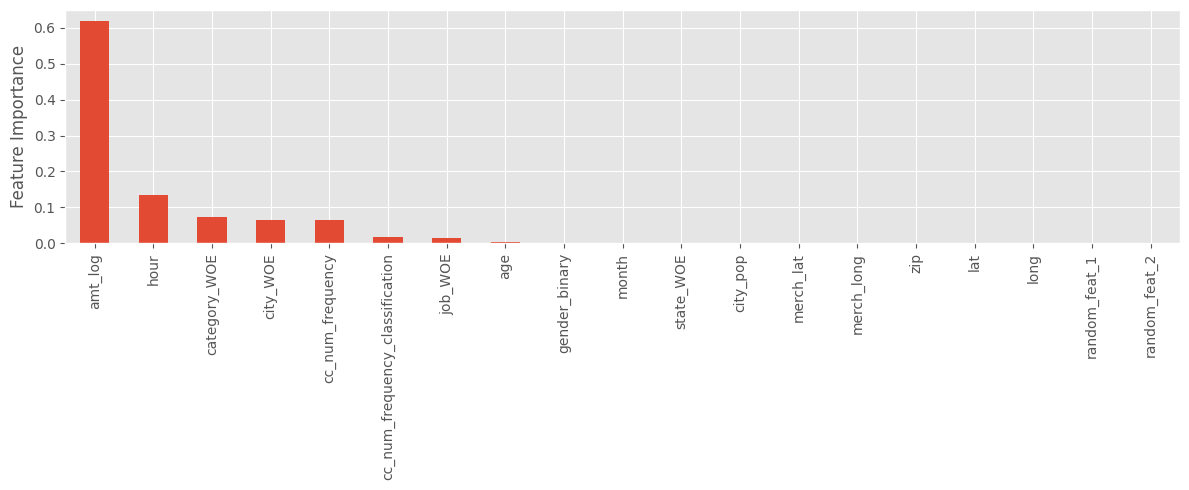

In [45]:
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots(figsize=(12, 5))
forest_importances.sort_values(ascending=False).plot.bar(ax=ax)
ax.set_ylabel("Feature Importance")
fig.tight_layout();

Now we proceed to select our features. Since "cc_num_frequency" and "cc_num_frequency_classification" is the same information, we are going to drop the less important.

In [46]:
X_train.drop(columns=["gender_binary", "state_WOE", "zip", "long", "lat",
                      "city_pop", "month", "cc_num_frequency_classification",
                      "random_feat_1", "random_feat_2", "merch_long"], inplace=True)

In [47]:
X_train.head()

,merch_lat,age,hour,amt_log,category_WOE,city_WOE,job_WOE,cc_num_frequency
0,29.24,24,5,3.89,-0.21,0.14,0.35,2556
1,41.56,52,7,4.65,0.90,0.20,0.70,1548
2,46.60,67,18,2.39,-0.70,0.77,0.11,1040
3,33.09,48,5,3.63,-0.61,0.00,-0.23,1548
4,48.08,45,23,1.42,1.12,-3.03,-0.90,3030


Finally, this is the features that are entering the model.

# Preparing test data

Let's apply the same transformations on test data.

In [48]:
test = pd.read_csv(r"data\fraudTest.csv", index_col=0)

test['age'] = dt.date.today().year-pd.to_datetime(test['dob']).dt.year
test['hour'] = pd.to_datetime(test['trans_date_trans_time']).dt.hour
test['month'] = pd.to_datetime(test['trans_date_trans_time']).dt.month

test.drop(columns=["merchant", "first", "last", "street",
                   "unix_time", "trans_num"], inplace=True)

test["amt_log"] = np.log1p(test["amt"])

test = apply_woe(test, columns_to_encode, target_column)

test["gender_binary"] = test["gender"].map(gender_mapping)

freq_enc_test = (test.groupby("cc_num").size())
freq_enc_test.sort_values(ascending=True)
test["cc_num_frequency"] = test["cc_num"].apply(lambda x: freq_enc_test[x])
test["cc_num_frequency_classification"] = test["cc_num_frequency"].apply(
    classify_frequency)

X_test = test.drop(columns=["trans_date_trans_time",
                            "city", "state", "category", "gender", "dob", "job", "cc_num", "amt", "is_fraud"])

y_test = test["is_fraud"]

X_test.drop(columns=["gender_binary", "state_WOE", "zip", "long", "lat",
                     "city_pop", "month", "cc_num_frequency_classification", "merch_long"], inplace=True)

# Training the model

In [90]:
model = RandomForestClassifier(random_state=23)
model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)
y_score_test = model.predict_proba(X_test)[:,1]

Let's create a function to help us evaluating the model!

In [146]:
def evaluate_model(target, predicted, y_score, normalize_matrix= None):
    accuracy = metrics.accuracy_score(target, predicted)
    precision = metrics.precision_score(target, predicted)
    recall = metrics.recall_score(target, predicted)
    f1 = f1_score(target, predicted)
    auc = metrics.roc_auc_score(target, y_score)

    confusion_matrix = metrics.confusion_matrix(
        target, predicted, normalize=normalize_matrix)
    cm_display = metrics.ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix, display_labels=[False, True])
    cm_display.plot()
    plt.grid(False)
    plt.show()

    fpr, tpr, threshold = roc_curve(target, y_score)
    plt.plot(fpr, tpr, label="Model", c="blue")
    plt.plot([0, 1], [0, 1], linestyle="--", c="yellow")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    print("Accuracy", accuracy.round(2))
    print("Precision:", precision.round(2))
    print("Recall:", recall.round(2))
    print("F1 Score", f1.round(2))
    print("AUC:", auc)
    return None

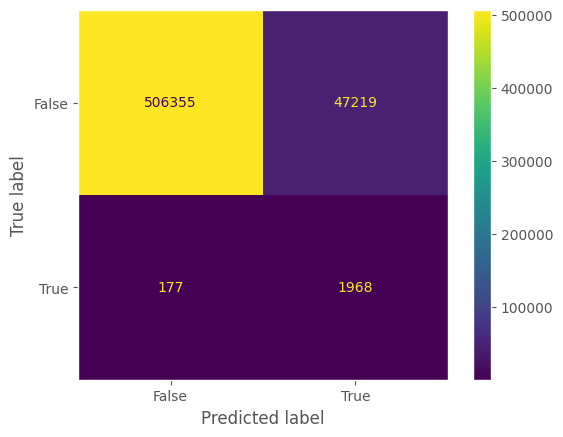

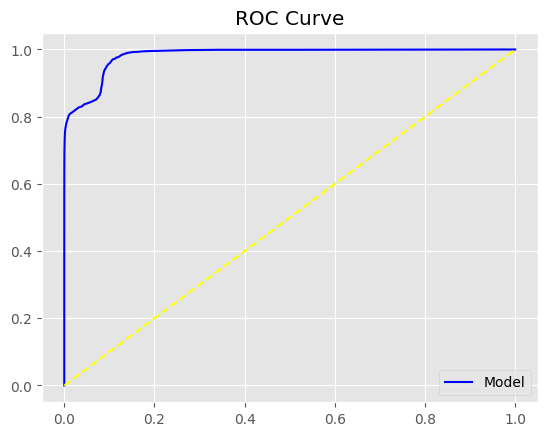

Accuracy 0.91
Precision: 0.04
Recall: 0.92
F1 Score 0.08
AUC: 0.982758712587245


In [105]:
evaluate_model(y_test, y_pred_test, y_score_test)

## Tuning the model

Let's tune the model using Bayesian optimization. For this, we'll use the library skopt.

In [126]:
def tune_model(params):
    n_estimators = params[0]
    max_depth = params[1]
    max_features = params[2]
    max_leaf_nodes = params[3]
    criterion = params[4]
    
    print(params, "\n")
    
    mdl = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                 max_features=max_features, max_leaf_nodes=max_leaf_nodes,
                                 criterion=criterion, random_state=23)
    mdl.fit(X_train, y_train)

    p = mdl.predict_proba(X_test)[:, 1]

    return -metrics.roc_auc_score(y_test, p) #since the model is for minimizing, we'll use negative ROC.

Now we define the search-space.

In [115]:
space = [(25, 150, "uniform"), #n_estimators
         (3,9), #max_depth
         ('sqrt', 'log2', None), #max_features
         (3,9), #max_leaf_nodes
         ("gini", "log_loss", "entropy")] #max_leaf_nodes

Let's run the model to find the best hyperparameters!

In [118]:
results_gp = gp_minimize(tune_model, space, random_state=23,
            verbose=1, n_calls=30, n_random_starts=10)

Iteration No: 1 started. Evaluating function at random point.
[109, 4, None, 6, 'gini'] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 12.1068
Function value obtained: -0.8609
Current minimum: -0.8609
Iteration No: 2 started. Evaluating function at random point.
[48, 4, 'sqrt', 8, 'gini'] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 2.6460
Function value obtained: -0.9603
Current minimum: -0.9603
Iteration No: 3 started. Evaluating function at random point.
[119, 9, 'sqrt', 9, 'gini'] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 6.5670
Function value obtained: -0.9623
Current minimum: -0.9623
Iteration No: 4 started. Evaluating function at random point.
[110, 8, 'log2', 5, 'gini'] 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 6.3030
Function value obtained: -0.9540
Current minimum: -0.9623
Iteration No: 5 started. Evaluating function at random point.
[74, 7, None, 8, 'entropy'] 

Iteration 

In [119]:
results_gp.x

[150, 9, None, 9, 'entropy']

In [124]:
model_gp = RandomForestClassifier(random_state=23, n_estimators=150,
                                  max_depth=9, max_features=None, max_leaf_nodes=9, criterion="entropy")
model_gp.fit(X_train, y_train)

y_pred_train_gp = model_gp.predict(X_train)
y_score_train_gp = model_gp.predict_proba(X_train)[:,1]

y_pred_test_gp = model_gp.predict(X_test)
y_score_test_gp = model_gp.predict_proba(X_test)[:,1]

Let's see the results for the tuned model for train and test (We'll evaluate both of them to identify possible overfitting)

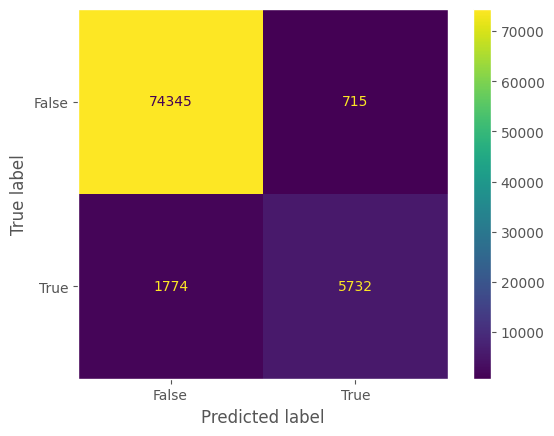

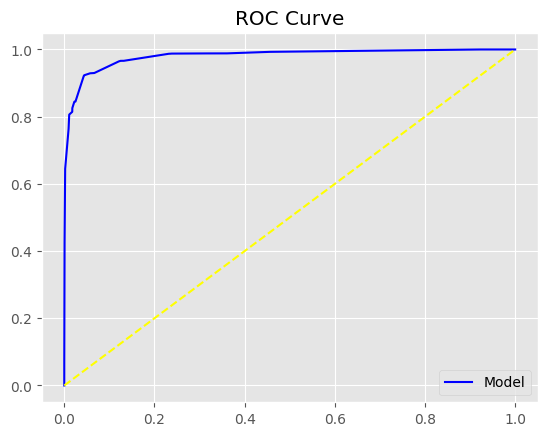

Accuracy 0.97
Precision: 0.89
Recall: 0.76
F1 Score 0.82
AUC: 0.9804459984725604


In [123]:
evaluate_model(y_train, y_pred_train_gp, y_score_train_gp)

Now we evaluate with test data.

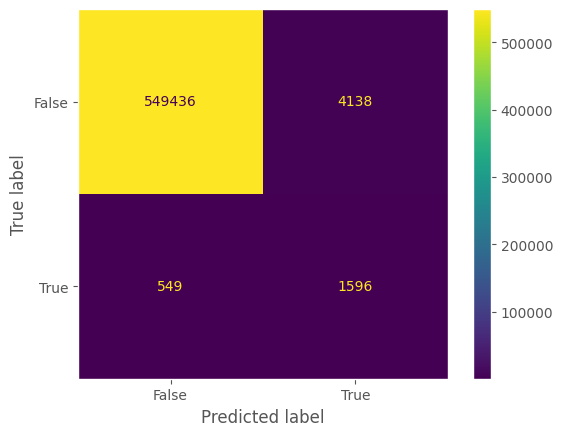

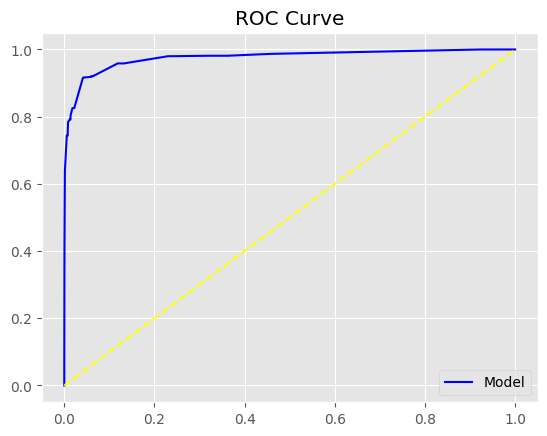

Accuracy 0.99
Precision: 0.28
Recall: 0.74
F1 Score 0.41
AUC: 0.97632619692254


In [125]:
evaluate_model(y_test, y_pred_test_gp, y_score_test_gp)

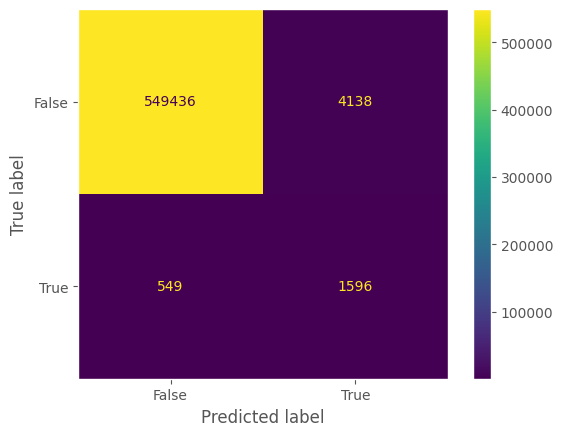

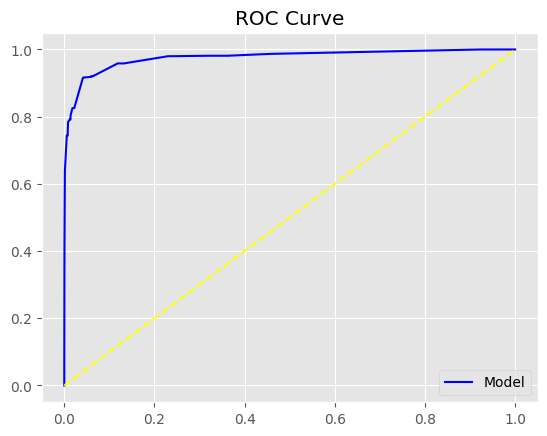

Accuracy 0.99
Precision: 0.28
Recall: 0.74
F1 Score 0.41
AUC: 0.97632619692254


In [153]:
evaluate_model(y_test, y_pred_test_gp, y_score_test_gp)